# RAG evaluation

# 0. Set up

In [1]:
from textstat import flesch_reading_ease
from bert_score import BERTScorer
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import logging
logging.set_verbosity_error()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import TypedDict

In [2]:
class TPPIResult(TypedDict):
    TPPI: float
    BertScore: float
    Normalized_BertScore: float
    Perplexity: float
    Normalized_Perplexity: float
    Flesch: float
    Normalized_Flesch: float


class TPPI:
    def __init__(self, model_type: str = 'bert-base-uncased'):
        """
        Inicializa el normalizador de puntuaciones y los modelos necesarios para los cálculos.
        """
        self.scorer = BERTScorer(model_type=model_type)
        self.gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Set the maximum lenght for GPT-2
        self.perplexity_max_length = 1024

    @staticmethod
    def normalize_bert_score(bert_score: float) -> float:
        """
        Normaliza el puntaje BERT en un rango de 0 a 1.
        """
        return (bert_score + 1) / 2

    @staticmethod
    def normalize_perplexity(perplexity: float) -> float:
        """
        Normaliza el valor de la perplejidad en un rango de 0 a 1.
        """
        # Aseguramos que la perplexidad mínima sea al menos 1 para evitar división por cero
        perplexity = max(perplexity, 1)
        # Invertimos la fórmula para que valores bajos de perplexidad den valores altos normalizados
        return 1 - (min(perplexity, 100) - 1) / 99

    @staticmethod
    def normalize_flesch(flesch: float) -> float:
        """
        Normaliza el puntaje de Flesch en un rango de 0 a 1.
        """
        return max(min(flesch, 100), 0) / 100

    def calculate_bert_score(self, reference_text: str, generated_text: str) -> float:
        """
        Calcula el BertScore entre un texto de referencia y uno generado.
        """
        P, R, F1 = self.scorer.score([reference_text], [generated_text], verbose=False)
        bert_score = F1.item()
        return bert_score

    def calculate_perplexity(self, text: str) -> float:
        """
        Calcula la perplejidad de un texto utilizando el modelo GPT-2.
        """
        # Tokenize the input text
        encode = self.gpt2_tokenizer.encode(text, return_tensors='pt')
    
        # Trim the input if it exceeds the maximum length
        if encode.size(1) > self.perplexity_max_length:  # Check the token sequence length
            encode = encode[:, :self.perplexity_max_length]  # Trim to the first max_length tokens
    
        # Calculate the perplexity
        with torch.no_grad():
            loss = self.gpt2_model(encode, labels=encode)[0]
        perplexity = torch.exp(loss).item()
        
        return perplexity

    @staticmethod
    def calculate_flesch(text: str) -> float:
        """
        Calcula el puntaje de Flesch Reading Ease de un texto.
        """
        flesch_score = flesch_reading_ease(text)
        return flesch_score

    def calculate_tppi(self, original_text: str, generated_text: str) -> TPPIResult:
        """
        Calcula el TPPI basado en los textos de referencia y generados, devolviendo los puntajes de BERT,
        perplejidad y Flesch tanto normalizados como sin normalizar.
        """
        # Calcula BertScore
        bert_score = self.calculate_bert_score(original_text, generated_text)
        normalized_bert_score = self.normalize_bert_score(bert_score)

        # Calcula Perplejidad
        perplexity = self.calculate_perplexity(generated_text)
        normalized_perplexity = self.normalize_perplexity(perplexity)

        # Calcula Flesch
        flesch = self.calculate_flesch(generated_text)
        normalized_flesch = self.normalize_flesch(flesch)

        # Calcula TPPI
        tppi_score = 0.5 * normalized_bert_score + 0.25 * normalized_perplexity + 0.25 * normalized_flesch

        # Devuelve todos los valores en un TypedDict
        return TPPIResult(
            TPPI=tppi_score,
            BertScore=bert_score,
            Normalized_BertScore=normalized_bert_score,
            Perplexity=perplexity,
            Normalized_Perplexity=normalized_perplexity,
            Flesch=flesch,
            Normalized_Flesch=normalized_flesch
        )

tppi = TPPI()

/Users/alejandro.medrano/.local/share/virtualenvs/UNITE_TALKING_POINTS-QWuKLflF/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 1. Load results

In [3]:
model_exp = pd.read_csv('model_exp.csv')

In [4]:
model_exp

,Unnamed: 0,file_name,model,experiment_number,content,prompt,generated_doc
0,0,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-3.5-turbo,1,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,- Generative Artificial Intelligence (AI) has ...
1,1,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-3.5-turbo,2,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,- Generative Artificial Intelligence (AI) has ...
2,2,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-3.5-turbo,3,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,"- Generative Artificial Intelligence, such as ..."
3,3,BN DOS USG on Implementation of Digital Transf...,gpt-3.5-turbo,1,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...,- Importance of Partnerships:\n - Collaborati...
4,4,BN DOS USG on Implementation of Digital Transf...,gpt-3.5-turbo,2,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...,- Importance of partnerships with the private ...
...,...,...,...,...,...,...,...
265,265,2023-09-15 Opening Remarks UNGS ScienceSummit ...,gpt-4o,2,Introduction and Welcome: Emphasize the role o...,Generate a set of talking points for a keynote...,### Talking Points for Keynote Address at Inte...
266,266,2023-09-15 Opening Remarks UNGS ScienceSummit ...,gpt-4o,3,Introduction and Welcome: Emphasize the role o...,Generate a set of talking points for a keynote...,**Talking Points for Keynote Address at Intern...
267,267,2022-08-02 TECH ENVOY TPs cybersecurity.json,gpt-4o,1,"Trust in the integrity, reliability and securi...",Generate talking points on the importance of t...,- **Critical Role of Trust in Digital Transfor...
268,268,2022-08-02 TECH ENVOY TPs cybersecurity.json,gpt-4o,2,"Trust in the integrity, reliability and securi...",Generate talking points on the importance of t...,### Talking Points on the Importance of Trust ...


In [5]:
temperatura_exp = pd.read_csv('temperature_exp.csv')

In [6]:
temperatura_exp

,Unnamed: 0,file_name,model,temperature,experiment_number,content,prompt,generated_doc
0,0,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-4o,0.0,1,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,### Talking Points on Recent Breakthroughs in ...
1,1,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-4o,0.0,2,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,### Talking Points on Recent Breakthroughs in ...
2,2,PSGD 2023-03-06 Talking Points for USG DOS on ...,gpt-4o,0.0,3,Generative Artificial Intelligence is a form o...,Generate talking points addressing the recent ...,### Talking Points on Recent Breakthroughs in ...
3,3,BN DOS USG on Implementation of Digital Transf...,gpt-4o,0.0,1,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...,### Talking Points on the Partnership between ...
4,4,BN DOS USG on Implementation of Digital Transf...,gpt-4o,0.0,2,DOS is a partner in the digital transformation...,Create talking points highlighting the partner...,### Talking Points on the Partnership between ...
...,...,...,...,...,...,...,...,...
445,445,2023-09-15 Opening Remarks UNGS ScienceSummit ...,gpt-4o,2.0,2,Introduction and Welcome: Emphasize the role o...,Generate a set of talking points for a keynote...,**Keynote Address Talking Points**\n\n- **Intr...
446,446,2023-09-15 Opening Remarks UNGS ScienceSummit ...,gpt-4o,2.0,3,Introduction and Welcome: Emphasize the role o...,Generate a set of talking points for a keynote...,### Infusion e Its Potentialientras Gonzalez;\...
447,447,2022-08-02 TECH ENVOY TPs cybersecurity.json,gpt-4o,2.0,1,"Trust in the integrity, reliability and securi...",Generate talking points on the importance of t...,"Based on the given context, here are hik l..."
448,448,2022-08-02 TECH ENVOY TPs cybersecurity.json,gpt-4o,2.0,2,"Trust in the integrity, reliability and securi...",Generate talking points on the importance of t...,### Trust in Digital Tools and Networks in Rea...


## 2. Analysis

### 2.1 Model experiment

In [39]:
all_results = model_exp.apply(lambda row: tppi.calculate_tppi(row['content'], row['generated_doc']), axis=1)

In [43]:
all_results = pd.concat([model_exp, pd.DataFrame(all_results.to_list())], axis=1)

In [44]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('model').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

           model      TPPI                               BertScore Perplexity  \
                      mean       std       min       max      mean       mean   
0  gpt-3.5-turbo  0.616521  0.037536  0.473600  0.744291  0.713561  31.302954   
1         gpt-4o  0.645606  0.025206  0.603961  0.715372  0.668183  18.871910   
2    gpt-4o-mini  0.640422  0.023794  0.599073  0.709320  0.665543  20.302018   

      Flesch  
        mean  
0 -22.472444  
1   8.942333  
2   8.819667  


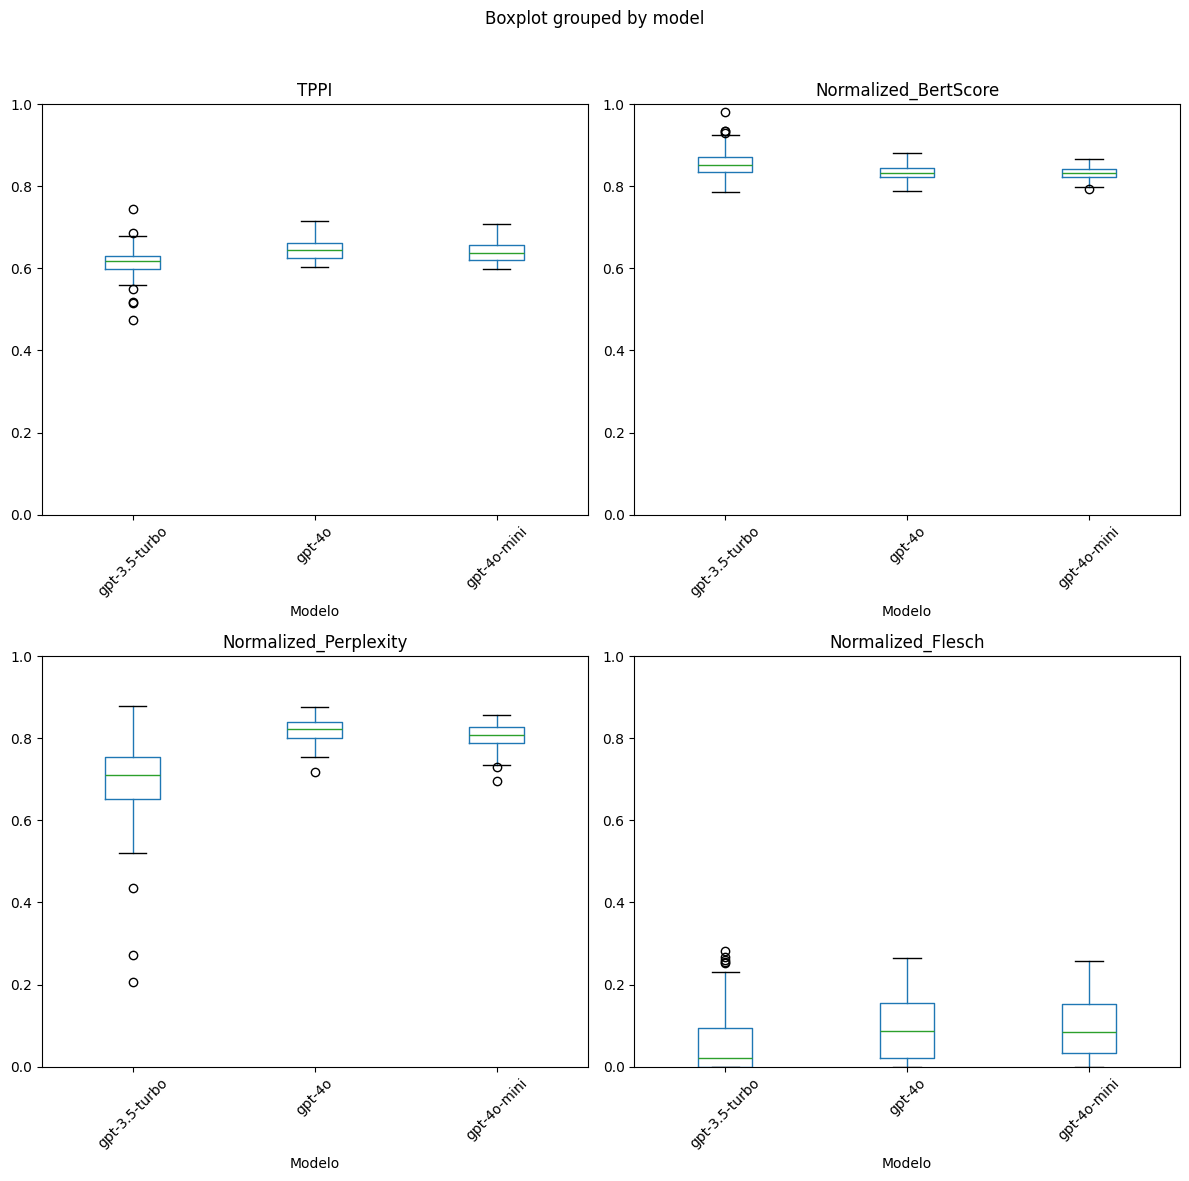

In [45]:
# Definir los nombres de las métricas para iterar
metrics = ['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch']

# Crear un subplot 2x2 para los boxplots de cada métrica
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.suptitle('Distribución de Métricas por Método de Vectorización', fontsize=16)

# Iterar sobre las métricas y los ejes para crear los boxplots
for ax, metric in zip(axes.flatten(), metrics):
    all_results.boxplot(column=metric, by='model', ax=ax, grid=False)
    ax.set_title(metric)
    ax.set_xlabel('Modelo')
    ax.set_ylim(0, 1)  # Asegurar que el gráfico esté limitado entre 0 y 1
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotar las etiquetas para mejor legibilidad

# Ajustar el layout para evitar la superposición de los títulos y etiquetas
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta los límites del rectángulo del layout
plt.show()

### 2.2 Temperature experiment

In [7]:
all_results = temperatura_exp.apply(lambda row: tppi.calculate_tppi(row['content'], row['generated_doc']), axis=1)

In [8]:
all_results = pd.concat([temperatura_exp, pd.DataFrame(all_results.to_list())], axis=1)

In [11]:
# Calcula estadísticas básicas para cada método
statistics = all_results.groupby('temperature').agg({
    'TPPI': ['mean', 'std', 'min', 'max'],
    'BertScore': ['mean'],
    'Perplexity': ['mean'],
    'Flesch' : ['mean']
}).reset_index()

print(statistics)

  temperature      TPPI                               BertScore  Perplexity  \
                   mean       std       min       max      mean        mean   
0         0.0  0.651241  0.024404  0.610549  0.716621  0.668875   17.171157   
1         0.5  0.646792  0.026783  0.598749  0.719217  0.665591   18.341690   
2         1.0  0.637044  0.027628  0.585842  0.720188  0.657970   20.843248   
3         1.5  0.410373  0.031417  0.365530  0.620128  0.533405  692.077539   
4         2.0  0.383090  0.031287  0.335752  0.649636  0.360083  582.045013   

      Flesch  
        mean  
0   9.347111  
1   9.058778  
2   8.307667  
3   8.289556  
4  16.892111  


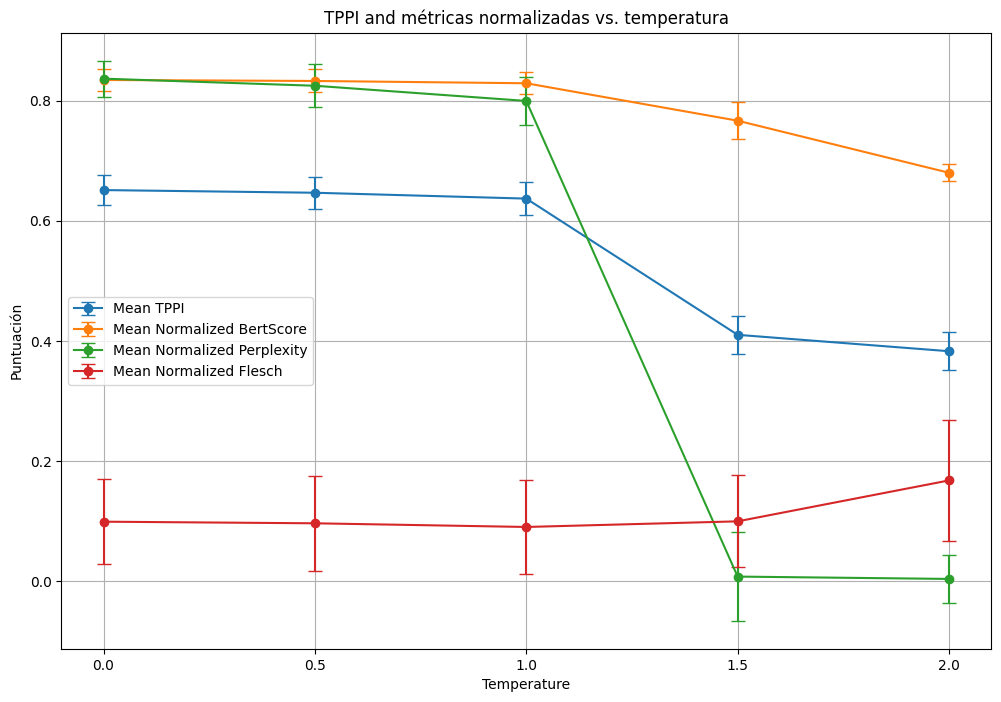

In [10]:
# Calculating mean values for each 'n'
mean_values = all_results[['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch', 'temperature']].groupby('temperature').mean().reset_index()
# Generating error bars (standard deviation as an example)
std_values = all_results[['TPPI', 'Normalized_BertScore', 'Normalized_Perplexity', 'Normalized_Flesch', 'temperature']].groupby('temperature').std().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.errorbar(mean_values['temperature'], mean_values['TPPI'], yerr=std_values['TPPI'], marker='o', label='Mean TPPI', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_BertScore'], yerr=std_values['Normalized_BertScore'], marker='o', label='Mean Normalized BertScore', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_Perplexity'], yerr=std_values['Normalized_Perplexity'], marker='o', label='Mean Normalized Perplexity', capsize=5)
plt.errorbar(mean_values['temperature'], mean_values['Normalized_Flesch'], yerr=std_values['Normalized_Flesch'], marker='o', label='Mean Normalized Flesch', capsize=5)

plt.title('TPPI and métricas normalizadas vs. temperatura')
plt.xlabel('Temperature')
plt.ylabel('Puntuación')
plt.xticks(mean_values['temperature'])  # Ensure x-axis labels match the temperature values
plt.legend()
plt.grid(True)
plt.show()